# Logistic Regression

Most of the machine learning concepts in my recent posts have had convenient closed-form solutions for optimal weights. Most problems in machine learning don't!
For example, neural networks usually have to use stochastic gradient descent to optimize weights.

In this post, I walk through logistic regression (which can also be thought of as a one-neuron neural network!) Optimal weights in logistic regression requires an iterative optimizer.

See also:
 - [MLPR notes](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/w3c_logistic_regression.html)
 - Section 17.4 of Barber's Bayesian Reasoning and Machine Learning
 - Section 4.3.2 of Bishop's Pattern Recognition and Machine Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import check_grad

# helper functions you can skip over :D
def hide_ticks(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)

SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

## Problem and data generation

Logistic regression can be used for classification. For example, if I have a bunch of observed data points that belong to class A and class B, I can pick a new point and ask which class the model thinks the point belongs to.

For this demo, I'll generate two groups of points that correspond to the two classes.

In [22]:
N = 100
D = 2

def get_observations(N):
    assert N % 2 == 0, 'sorry, N should be even for the following code to work'

    center_A = [-1, -1]
    center_B = [1, 1]

    data_A = np.random.randn(N//2, D) + center_A
    data_B = np.random.randn(N//2, D) + center_B

    shuffle_indices = np.arange(N)
    np.random.shuffle(shuffle_indices)

    # stack the data and labels, and then shuffle it according to our shuffle indices
    data = np.vstack((data_A, data_B))[shuffle_indices]
    labels = np.hstack((np.ones(N//2), np.zeros(N//2)))[shuffle_indices]
    
    return data, labels

fuzzy_data, fuzzy_labels = get_observations(N)

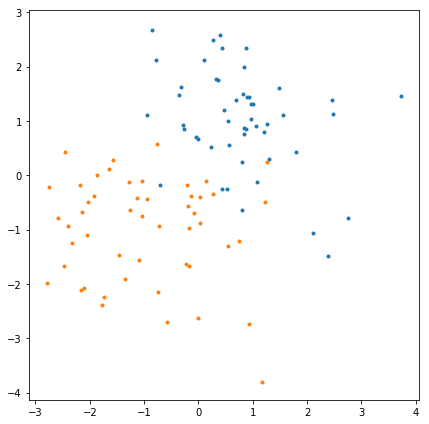

In [24]:
def plot_labeled_data(ax, data, labels):
    '''
    ax: matplotlib axis
    data: (N, D) 2D data points
    labels: (N,) label of 0 or 1
    '''
    ax.plot(*data[labels == 0].T, '.')
    ax.plot(*data[labels == 1].T, '.')

plt.figure(figsize=(6, 6))
plot_labeled_data(plt, fuzzy_data, fuzzy_labels)
plt.axis('square')
maybe_save_plot('2018-05-22-fuzzy')
plt.show()

Note: We could also learn this without iterative optimization using [Bayes classifiers](https://github.com/jessstringham/blog/blob/master/notebooks/2018-05-04-ipywidgets-for-learning-logistic-sigmoid-and-bayes-classifiers.ipynb). But these require quadratically more parameters than logistic regression (see Bishop for more info).

## Logistic sigmoid

Logistic regression learns the weights of a logistic sigmoid function. The logistic sigmoid is given by:

$$\sigma(\textbf{w}^{\top}\textbf{x} + b) = \frac{1}{1 + \exp(-\textbf{w}^{\top}\textbf{x} + b)}$$

where $\textbf w$ and $b$ are the weights I want to learn and $\textbf{x}$ is the input data.
$\sigma$ ranges from 0 to 1. In the case of logistic regression, its value is treated as the probability that a point $\textbf{x}$ falls into one of the two classes.

I'll define a `sigmoid_with_bias` function I can use. (Heads up, I combine the bias with the rest of the weights.)

In [4]:
def sigmoid_with_bias(bias_and_weights, x):
    '''
    bias_and_weights: (D + 1,) bias and array of weights in one array
    x: (N, D) data
    '''
    # use w[0] as the bias term, and the rest as weights
    bias = bias_and_weights[0]
    weights = bias_and_weights[1:]
    return 1/(1 + np.exp(-(weights.T @ x + bias)))

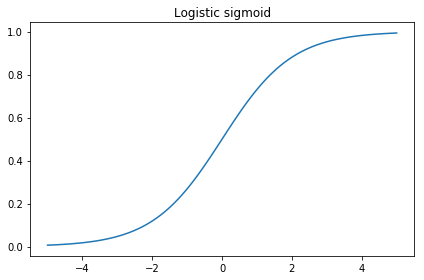

In [26]:
xs = np.linspace(-5, 5, 100)
plt.plot(xs, sigmoid_with_bias(np.array([0, 1]), xs[None, :]))
plt.title('Logistic sigmoid')
maybe_save_plot('2018-05-22-sigmoid')
plt.show()

*(Oh hey, my [ipywidgets post](https://github.com/jessstringham/blog/blob/master/notebooks/2018-05-04-ipywidgets-for-learning-logistic-sigmoid-and-bayes-classifiers.ipynb) has an interactive example of how the weights and bias influence the shape of the sigmoid.)*

### Sigmoid with two input variables

My data has two input variables, so I'd like a function that takes in two inputs and returns the probability that the point belongs to class A. The `sigmoid_with_bias` defined above can do this.

To demonstrate, I can plot sigmoid with two input dimensions (and a 3rd output dimension) using a contour plot.

Below I plot the contours for a $\sigma$ using $\textbf w = \begin{bmatrix}3/2 \\ -2\end{bmatrix}$ and $b = 2$. The graph shows a region where $\sigma$ is close to 1, another region where $\sigma$ is close to 0, and a sloping boundary in between. If I were to view the boundary from the side, I'd get something like the sigmoid shape shown above. 

If a data point is in the area on this slope, I'd say things like "I'm 80% sure that this point is in class B". This is useful for where the data from the two classes overlap, such as the example data.

In [27]:
MIN_GRID_VAL = -5
MAX_GRID_VAL = 5

xgrid = np.linspace(MIN_GRID_VAL, MAX_GRID_VAL, 100)
ygrid = xgrid

def plot_sigmoid(ax, w, data, labels):
    '''
    ax: matplotlib axis
    w: (D,) numpy array of weights for the sigmoid, where first value is bias term
    data: (N, D - 1) data points
    labels: (N,) labels 1s and 0s
    '''
    X, Y = np.meshgrid(xgrid, ygrid)
    
    # I'm not sure if there's a better way to do this. I'm flattening the grid down, computing
    # the results, and reshaping it back into the form wanted by `contour`
    flattened_x_y = np.dstack((X, Y)).reshape(-1, 2).T
    sigmoid_vals = sigmoid_with_bias(w, flattened_x_y).reshape(xgrid.shape[0], ygrid.shape[0])
    
    CS = ax.contour(X, Y, sigmoid_vals, colors='k', levels=np.arange(0, 1, 0.125))
    ax.clabel(CS, inline=1, fontsize=13)
    
    return sigmoid_vals

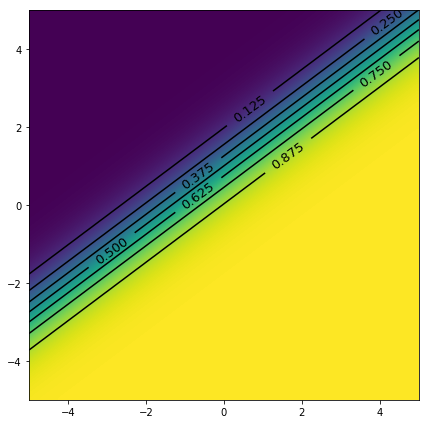

In [28]:
w = np.hstack([2, 3/2, -2])
data = fuzzy_data
labels = fuzzy_labels

plt.figure(figsize=(6, 6))

sigmoid_vals = plot_sigmoid(plt, w, data, labels)

plt.imshow(
    sigmoid_vals, 
    interpolation='bilinear', 
    origin='lower', 
    extent=(MIN_GRID_VAL, MAX_GRID_VAL, MIN_GRID_VAL, MAX_GRID_VAL)
)

plt.axis('square')
maybe_save_plot('2018-05-22-2d-sigmoid')
plt.show()

If I drop this sigmoid on the Fuzzy Data, it looks like this $\textbf w$ and $b$ make a terrible boundary.

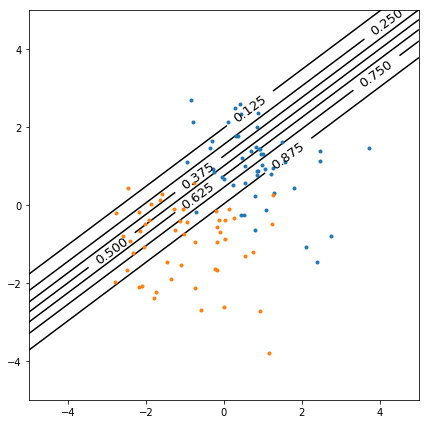

In [29]:
plt.clf()
plt.figure(figsize=(6, 6))
plot_sigmoid(plt, w, fuzzy_data, fuzzy_labels)    
plot_labeled_data(plt, fuzzy_data, fuzzy_labels)
plt.axis('square')
maybe_save_plot('2018-05-22-bad-fit')
plt.show()

## Optimizers

Later I'll need to use an optimizer to find the best weights, so here I'll show how `minimize` works. I'll try to minimize the function $x^2 - 2x$. 
I also need to provide the gradient of $f$. Because that can be tricky to get right, I'll run `check_grad`, a method in `scipy` that numerically checks the gradient. I'll also need an initial weight for the minimizer to start at.

When I run this, the minimum is in `example_optimizer_result.x`, and is $x = 1$.

In [33]:
# Check gradients at an arbitrary spot!
# `check_grad` returns the difference, which is close to 0.
# Heads up, I'm not sure how close to 0 to expect this to be, so I chose an arbitrary value that worked.
# Look into this more before using it for reals.
def assert_grad_is_close(f, grad_f, x0):
    assert np.isclose(check_grad(f, grad_f, x0=x0), 0, atol=1e-2), 'grads are diff: {}'.format(check_grad(f, grad_f, x0=x0))

def f(x):
    return x**2 - 2 * x

def grad_f(x):
    return 2 * x - 2

assert_grad_is_close(f, grad_f, np.array([3]))

example_optimizer_result = minimize(f, x0=3, jac=grad_f, method='BFGS')

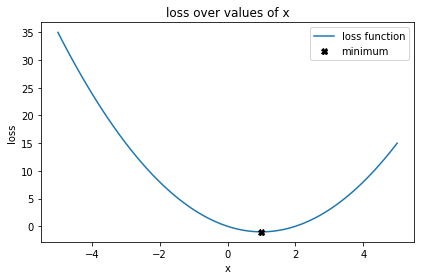

In [34]:
plt.plot(xgrid, f(xgrid), label='loss function')
plt.plot(example_optimizer_result.x, f(example_optimizer_result.x), 'Xk', label='minimum')
plt.title('loss over values of x')
plt.xlabel('x')
plt.ylabel('loss')
plt.legend()
maybe_save_plot('2018-05-22-optimizer')
plt.show()

## Maximum Likelihood of Logistic Regression

One way to learn a better value of $\textbf w$ and $b$ given the labeled observations is by using maxmimum likelihood.  I'll use the equations from Chapter 17 of [Barber](http://www0.cs.ucl.ac.uk/staff/d.barber/brml/).

(Heads up, I moved the bias $b$ into weights $\textbf w$ by adding a column of 1's to $\textbf x$.)

To find the $\textbf w$ using maximum likelihood, I find $\textbf w^*$ so that

$$\textbf w^* = \mathrm{argmax}_{\textbf w} \log P(\mathcal{D} \mid \textbf w)$$

where $\mathcal{D}$ is the observed data. Using $\textbf x_n$ as an input and $y_n$ as a label from an observation, the log likelihood is given by the sum over all observations of the probabilities, or

\begin{align}
\log P(\mathcal{D} \mid \textbf w) &= \sum_n \log P(\textbf x_n, y_n \mid \textbf w) . \\
\end{align}

For this logistic regression set-up, $\log P(\textbf x_n, y_n \mid \textbf w)$ becomes

$$\log P(\textbf x_n, y_n \mid \textbf w) = y_n\log\sigma(\textbf w^\top \textbf x_n) + (1 - y_n)\log(1 - \sigma(\textbf w^\top \textbf x_n)).$$

The goal is to find the value of $\textbf w$ that maximizes $\log P(\mathcal{D} \mid \textbf w)$. 
There is no closed-form solution, so I'll use an iterative optimizer. As above, iterative optimizers sometimes require the gradient with respect to the weights, which for this logistic regression set-up is given by

$$\nabla_{\textbf w} \log P(\mathcal D \mid \textbf w) = \sum_n(y_n - \sigma(\textbf w^\top \textbf x_n))\textbf  x_n. $$

While there isn't a closed-form solution, it turns out that $\log P(\mathcal{D} \mid \textbf w)$ does have a single maximum, so I don't need to worry about local maxima. This makes logistic regression different than other models where multiple runs gives different results.

Finally, I'll add a regularizer to keep the weights reasonable. The equations with regularization are given by

$$\textbf w^* = \mathrm{argmax}_{\textbf w} \log P(\mathcal{D} \mid \textbf w) + \lambda \textbf w^{\top} \textbf w$$

$$\nabla_{\textbf w} \left(\log P(\mathcal{D} \mid \textbf w) + \lambda \textbf w^{\top} \textbf w\right) = \sum_n(y_n - \sigma(\textbf w^\top \textbf x_n))\textbf  x_n + 2 \lambda \mathbf{w}. $$

I return to why regularization is important below.

### Coding up equations

Now I translate the equations for $\log P(\mathcal{D} \mid \textbf w)$ and $\nabla_{\textbf w} \log P(\mathcal D \mid \textbf w)$ and the regularization terms into code.

In general:
 - $\log P(\mathcal{D} \mid \textbf w)$ should return a scalar
 - $\nabla_{\textbf w} \log P(\mathcal D \mid \textbf w)$ should return a vector the same size as $\textbf w$.

There are a few catches:
 - The optimizer I'm using, `minimize` , is a minimizer, so I'll actually minimize the _negative_ log likelihood.
 - $\log$ overflows when the sigmoid start returning values that round to 0. There might be better ways to solve this, but I avoid this by adding a tiny offset.
 - Because of how I'm dealing with the bias term, I have to explicitly make an $\textbf x$ with a column of ones here called `data_with_bias`.
 - I'm returning the loss function as well so I can plot it. Eh.

In [38]:
def fit_logistic_regression(data, labels, regularization_constant, initial_w):
    epsilon = 1e-9
    
    data_with_bias = np.hstack((
        np.ones((data.shape[0], 1)), 
        data,
    ))
    
    def loss(w):
        return -np.sum(
            labels * np.log(sigmoid_with_bias(w, data.T) + epsilon) 
            + (1 - labels) * np.log(1 - sigmoid_with_bias(w, data.T) + epsilon)
        ) + regularization_constant * (w.T @ w)
    
    def grad_loss(w):
        return -(labels - sigmoid_with_bias(w, data.T)) @ data_with_bias + 2 * regularization_constant * w
    
    assert_grad_is_close(loss, grad_loss, w)
    
    opt_result = minimize(loss, x0=w, method='BFGS', jac=grad_loss)
    
    assert opt_result.success, opt_result
    
    return opt_result, loss

## Optimizing for logistic regression

Now I optimize those functions and plot the results.

In [40]:
log_reg_optimizer_result, loss_func = fit_logistic_regression(
    fuzzy_data,
    fuzzy_labels, 
    regularization_constant=0.1,
    initial_w=w,
)

print(log_reg_optimizer_result)

      fun: 15.919840119847468
 hess_inv: array([[ 0.17848323, -0.05018526,  0.00905405],
       [-0.05018526,  0.26530471,  0.17622941],
       [ 0.00905405,  0.17622941,  0.44592668]])
      jac: array([ -2.61269672e-06,   4.82700074e-06,  -2.26616311e-06])
  message: 'Optimization terminated successfully.'
     nfev: 19
      nit: 16
     njev: 19
   status: 0
  success: True
        x: array([ 0.1293201 , -2.03361611, -2.73868849])


          fun: 15.919840119847468
     hess_inv: array([[ 0.17848323, -0.05018526,  0.00905405],
           [-0.05018526,  0.26530471,  0.17622941],
           [ 0.00905405,  0.17622941,  0.44592668]])
          jac: array([ -2.61269672e-06,   4.82700074e-06,  -2.26616311e-06])
      message: 'Optimization terminated successfully.'
         nfev: 19
          nit: 16
         njev: 19
       status: 0
      success: True
            x: array([ 0.1293201 , -2.03361611, -2.73868849])

### Plotting the loss function

To visualize what the minimizer found, I'll plot the loss function, or the negative log likelihood with regularization, and the optimal $w$ found. While the real loss surface has three input dimensions, one for the bias and two for the weights, for visualization, I'll just vary one of the weights.

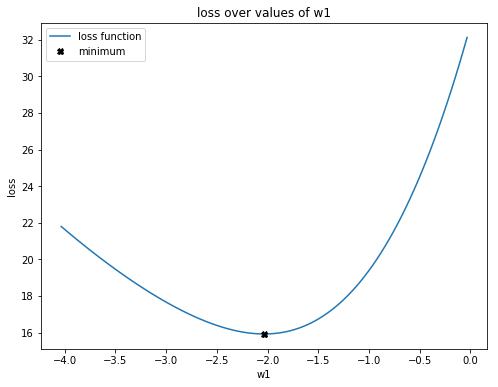

In [41]:
w0, w1, w2 = log_reg_optimizer_result.x
loss_xgrid = np.linspace(w1 - 2, w1 + 2, 100)

plt.figure(figsize=(8, 6))

# Plot the loss function
loss_over_w1 = np.hstack((
    loss_func(np.array([ w0, i, w2]))
    for i in loss_xgrid
))

plt.plot(loss_xgrid, loss_over_w1, label='loss function')
plt.plot(w1, loss_func(log_reg_optimizer_result.x), 'Xk', label='minimum')
plt.title('loss over values of w1')
plt.xlabel('w1')
plt.ylabel('loss')
plt.legend()
plt.show()

### Logistic sigmoid on the data with fitted weights

Plotting the logistic sigmoid with the fitted weights looks much better!

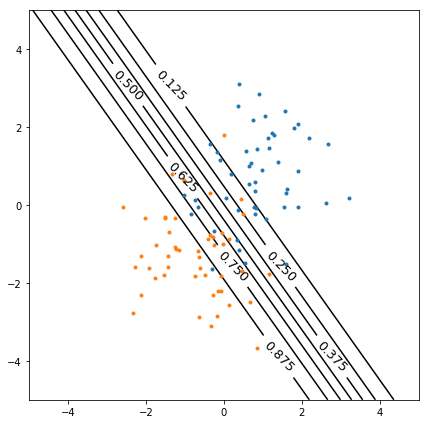

In [17]:
plt.figure(figsize=(8, 6))
plot_sigmoid(plt, log_reg_optimizer_result.x, fuzzy_data, fuzzy_labels)  
plot_labeled_data(plt, fuzzy_data, fuzzy_labels)
plt.axis('square')
maybe_save_plot('2018-05-22-2d-sigmoid')
plt.show()

## Regularization

Regularization is important in logistic regression. One problem with logistic regression is that if data is linearly separable, the boundary becomes super steep. 

I'll generate the data points, run logistic regression without regularization on it, and plot the boundary.

In [42]:
def get_lin_sep_observations(N):
    assert N % 2 == 0, 'sorry, N should be even for the following code to work'

    center_A = [-4, -4]
    center_B = [0, 0]

    data_A = 4 * np.random.rand(N//2, D) + center_A
    data_B = 4 * np.random.rand(N//2, D) + center_B

    shuffle_indices = np.arange(N)
    np.random.shuffle(shuffle_indices)

    # stack the data and labels, and then shuffle it according to our shuffle indices
    data = np.vstack((data_A, data_B))[shuffle_indices]
    labels = np.hstack((np.ones(N//2), np.zeros(N//2)))[shuffle_indices]
    
    return data, labels

lin_sep_data, lin_sep_labels = get_lin_sep_observations(N)

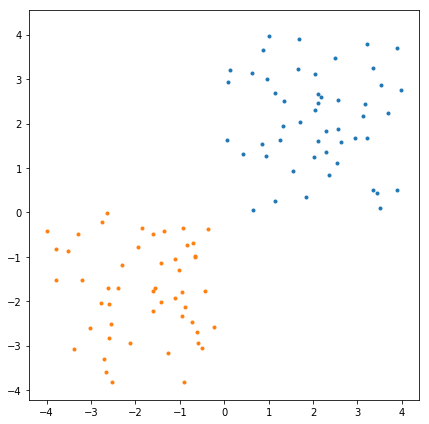

In [43]:
plt.figure(figsize=(6, 6))

plot_labeled_data(plt, lin_sep_data, lin_sep_labels)
plt.axis('square')
maybe_save_plot('2018-05-22-lin-sep')
plt.show()

In [44]:
no_reg_optimizer_result, _ = fit_logistic_regression(
    lin_sep_data,
    lin_sep_labels, 
    regularization_constant=0,  # setting the regularization constant as 0 is the same as no regularization
    initial_w=w,
)

reg_optimizer_result, _ = fit_logistic_regression(
    lin_sep_data,
    lin_sep_labels, 
    regularization_constant=0.1,
    initial_w=w,
)

very_reg_optimizer_result, _ = fit_logistic_regression(
    lin_sep_data,
    lin_sep_labels, 
    regularization_constant=10,
    initial_w=w,
)

The main thing I want to show is that with no regularization constant, the boundary will become as steep as it can until the optimizer gives up. I also show the effect of a higher regularization constant.

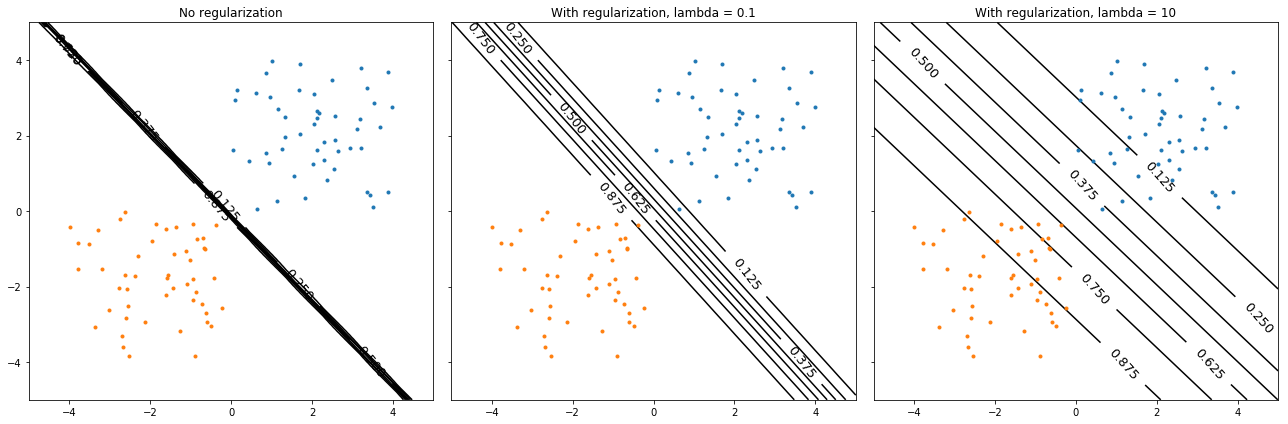

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axs[0].axis([-5, 5, -5, 5])

plot_sigmoid(axs[0], no_reg_optimizer_result.x, lin_sep_data, lin_sep_labels)    
plot_labeled_data(axs[0], lin_sep_data, lin_sep_labels)
axs[0].set_title('No regularization')

plot_sigmoid(axs[1], reg_optimizer_result.x, lin_sep_data, lin_sep_labels)    
plot_labeled_data(axs[1], lin_sep_data, lin_sep_labels)
axs[1].set_title('With regularization, lambda = 0.1')

plot_sigmoid(axs[2], very_reg_optimizer_result.x, lin_sep_data, lin_sep_labels)    
plot_labeled_data(axs[2], lin_sep_data, lin_sep_labels)
axs[2].set_title('With regularization, lambda = 10')

maybe_save_plot('2018-05-22-reg-vs-no')
plt.show()